##  Heston Model Calibration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import * 
from scipy.stats import norm
from scipy.optimize import fmin_bfgs
from scipy import *
from scipy.integrate import quad
from scipy import optimize

In [2]:
# Heston model solution
def heston_call_price(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K):
    p1 = p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K, 1)
    p2 = p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 ,K, 2)
    return (s0*p1-K*np.exp(-r*T)*p2)

def p(kappa, theta, sigma, rho, v0 ,r ,T ,s0 , K, status):
    integrand = lambda phi: (np.exp(-1j*phi*np.log(K))* 
    f(phi, kappa, theta, sigma, rho, v0, r, T, s0, status)/(1j*phi)).real    
    return (0.5+(1/pi)*quad(integrand,0,100)[0])

def f(phi, kappa, theta, sigma, rho, v0, r, T, s0, status): 
    if status==1:
        u = 0.5
        b = kappa-rho*sigma
    else:
        u = -0.5
        b = kappa
    
    a = kappa*theta
    x = np.log(s0)
    d = np.sqrt((rho*sigma*phi*1j-b)**2-sigma**2*(2*u*phi*1j-phi**2))
    g = (b-rho*sigma*phi*1j+d)/(b-rho*sigma*phi*1j-d)
    C = r*phi*1j*T+(a/sigma**2)*((b-rho*sigma*phi*1j+d)*T-2*np.log((1-g*np.exp(d*T))/(1-g)))
    D = (b-rho*sigma*phi*1j+d)/sigma**2*((1-np.exp(d*T))/(1-g*np.exp(d*T)))
    return np.exp(C+D*v0+1j*phi*x)

In [3]:
# Calibration(kappa, theta, sigma, rho, v0)
def calibrate(init_val, market_datas):
    def error(x):
        kappa, theta, sigma, rho, v0 = x
        print('x=',kappa, theta, sigma, rho, v0)
        result = 0.0
        for i in range(0,20):
            s0, k, market_price, r, T = market_datas.iloc[i]
            #print(s0, k, market_price, r, T)
            heston_price = heston_call_price(kappa, theta, sigma, rho, v0, r, T, s0, k)
            result += (heston_price - market_price)**2
            
        print('result',result)
        return result
    opt=optimize.least_squares(error,init_val)# ??? or fmin, or leastsq
    return opt

In [4]:
# Load market data
# S0  K  Call_Price  r  T
market_datas=pd.read_csv('data/SNP.csv')

In [5]:
market_datas

,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price
0,21.99,1.0,0.005616,0.0275,0.3434,0.0088,22.6
1,21.99,5.0,0.005616,0.0275,0.3434,0.0088,12.1
2,21.99,7.0,0.005616,0.0275,0.3434,0.0088,11.0
3,21.99,9.0,0.005616,0.0275,0.3434,0.0088,11.1
4,21.99,10.0,0.005616,0.0275,0.3434,0.0088,12.6
...,...,...,...,...,...,...,...
57511,50.09,50.0,2.170813,0.0410,0.3211,0.0088,8.8
57512,50.09,52.5,2.170813,0.0410,0.3211,0.0088,7.5
57513,50.09,55.0,2.170813,0.0410,0.3211,0.0088,7.0
57514,50.09,60.0,2.170813,0.0410,0.3211,0.0088,5.8


In [6]:
market_datas.drop(['Dividends','Volatility'],axis=1,inplace = True)

In [7]:
market_datas = market_datas[['Stock Price','Strike Price','Call Price','Risk-free','Maturity' ]]

In [8]:
# Initialize kappa, theta, sigma, rho, v0
init_val = [1.1,0.1,0.4,-0.0,0.1]

# Calibration of parameters
opt = calibrate(init_val, market_datas) #very slow!!!!!
kappa, theta, sigma, rho, v0=opt['x']

x= 1.1 0.1 0.4 -0.0 0.1
result 54.62322499574031
x= 1.1000000163912773 0.1 0.4 0.0 0.1
result 54.62322499574032
x= 1.1 0.1000000149011612 0.4 0.0 0.1
result 54.623224995770315
x= 1.1 0.1 0.4000000149011612 0.0 0.1
result 54.62322499573184
x= 1.1 0.1 0.4 1.4901161193847656e-08 0.1
result 54.62322499558897
x= 1.1 0.1 0.4 0.0 0.1000000149011612
result 54.623225005437355
x= 1.0999984294914658 0.09635225837243093 0.4010296253895483 0.01839764360066153 -1.0788329655044655
result 4.6812196590413005e+24
x= 1.0999996073728664 0.09908806459310773 0.4002574063473871 0.004599410900165382 -0.1947082413761164
result 2049.5828383258668
x= 1.0999999018432167 0.09977201614827694 0.4000643515868468 0.0011498527250413456 0.026322939655970906
result 54.546528238366
x= 1.0999999182344926 0.09977201614827694 0.4000643515868468 0.0011498527250413456 0.026322939655970906
result 54.54652823837211
x= 1.0999999018432167 0.09977203104943813 0.4000643515868468 0.0011498527250413456 0.026322939655970906
result 54.5

result 54.47078389558686
x= 1.0999879219767483 0.09962541029394559 0.40006631313704955 -0.000777358369340496 -0.020743694092163284
result 54.470783895586706
x= 1.0999879055856512 0.09962542519510678 0.40006631313704955 -0.000777358369340496 -0.020743694092163284
result 54.47078389558504
x= 1.0999879055856512 0.09962541029394559 0.40006632803821074 -0.000777358369340496 -0.020743694092163284
result 54.47078389558927
x= 1.0999879055856512 0.09962541029394559 0.40006631313704955 -0.0007773732705016899 -0.020743694092163284
result 54.47078389487944
x= 1.0999879055856512 0.09962541029394559 0.40006631313704955 -0.000777358369340496 -0.020743708993324478
result 54.470783896139004
x= 1.0999879967487167 0.0996265771683587 0.4000647679400728 -0.001231167679668854 -0.020389497568648194
result 54.47076297696492
x= 1.0999880131398152 0.0996265771683587 0.4000647679400728 -0.001231167679668854 -0.020389497568648194
result 54.47076297696535
x= 1.0999879967487167 0.09962659206951989 0.400064767940072

result 54.47057329759821
x= 1.099987694197771 0.09962547008431767 0.4000710147615647 -0.005260083505165628 -0.02081810615249552
result 54.47057329689263
x= 1.099987694197771 0.09962547008431767 0.4000710147615647 -0.005260068604004434 -0.020818121053656713
result 54.4705732981552
x= 1.0999877809732963 0.09962659278177352 0.40007461012062373 -0.005715020157652148 -0.02046539279267147
result 54.47055221139829
x= 1.0999877973643915 0.09962659278177352 0.40007461012062373 -0.005715020157652148 -0.02046539279267147
result 54.47055221139835
x= 1.0999877809732963 0.09962660768293471 0.40007461012062373 -0.005715020157652148 -0.02046539279267147
result 54.47055221139973
x= 1.0999877809732963 0.09962659278177352 0.4000746250217849 -0.005715020157652148 -0.02046539279267147
result 54.470552211392636
x= 1.0999877809732963 0.09962659278177352 0.40007461012062373 -0.005715035058813342 -0.02046539279267147
result 54.470552210705364
x= 1.0999877809732963 0.09962659278177352 0.40007461012062373 -0.005

result 54.470339696533486
x= 1.099988119301148 0.0996284042080751 0.40013496331910925 -0.010210047090781552 -0.020541552171138722
result 54.47033969653495
x= 1.099988119301148 0.09962838930691391 0.40013497822027044 -0.010210047090781552 -0.020541552171138722
result 54.47033969651994
x= 1.099988119301148 0.09962838930691391 0.40013496331910925 -0.010210061991942746 -0.020541552171138722
result 54.47033969583664
x= 1.099988119301148 0.09962838930691391 0.40013496331910925 -0.010210047090781552 -0.020541567072299916
result 54.47033969595885
x= 1.099988094599887 0.09962742926160473 0.400143567498767 -0.010654140502528955 -0.02090775964292076
result 54.47031827396595
x= 1.0999881109909868 0.09962742926160473 0.400143567498767 -0.010654140502528955 -0.02090775964292076
result 54.47031827396591
x= 1.099988094599887 0.09962744416276592 0.400143567498767 -0.010654140502528955 -0.02090775964292076
result 54.4703182739638
x= 1.099988094599887 0.09962742926160473 0.4001435823999282 -0.01065414050

result 54.47012521383262
x= 1.0999886500114382 0.09963005527415662 0.4002597045394788 -0.015164091643180846 -0.020982695351294718
result 54.47010359547184
x= 1.0999886664025464 0.09963005527415662 0.4002597045394788 -0.015164091643180846 -0.020982695351294718
result 54.47010359547119
x= 1.0999886500114382 0.09963007017531782 0.4002597045394788 -0.015164091643180846 -0.020982695351294718
result 54.47010359546948
x= 1.0999886500114382 0.09963005527415662 0.40025971944064 -0.015164091643180846 -0.020982695351294718
result 54.47010359544857
x= 1.0999886500114382 0.09963005527415662 0.4002597045394788 -0.01516410654434204 -0.020982695351294718
result 54.47010359475184
x= 1.0999886500114382 0.09963005527415662 0.4002597045394788 -0.015164091643180846 -0.020982710252455912
result 54.47010359602076
x= 1.0999890277493256 0.09963155471387004 0.40027449569930246 -0.015621741419087003 -0.020633786569304466
result 54.470082081919834
x= 1.0999890441404394 0.09963155471387004 0.40027449569930246 -0.0

result 54.46988691032785
x= 1.0999890728226873 0.09963342156818163 0.40042678315169106 -0.019686333876488958 -0.02105787115844262
result 54.469886909634795
x= 1.0999890728226873 0.09963342156818163 0.40042678315169106 -0.019686318975327764 -0.021057886059603813
result 54.469886910906695
x= 1.0999891301262095 0.0996347092473924 0.4004464585298418 -0.020145151495227605 -0.020710760568389944
result 54.469865197627634
x= 1.0999891465173248 0.0996347092473924 0.4004464585298418 -0.020145151495227605 -0.020710760568389944
result 54.46986519762771
x= 1.0999891301262095 0.0996347241485536 0.4004464585298418 -0.020145151495227605 -0.020710760568389944
result 54.46986519762872
x= 1.0999891301262095 0.0996347092473924 0.400446473431003 -0.020145151495227605 -0.020710760568389944
result 54.46986519759691
x= 1.0999891301262095 0.0996347092473924 0.4004464585298418 -0.0201451663963888 -0.020710760568389944
result 54.469865196921795
x= 1.0999891301262095 0.0996347092473924 0.4004464585298418 -0.02014

result 54.46964612237736
x= 1.0999895266089856 0.0996395424695712 0.40066965845961405 -0.024682353795242744 -0.02078819057359135
result 54.469646122378265
x= 1.0999895266089856 0.09963952756841 0.40066967336077525 -0.024682353795242744 -0.02078819057359135
result 54.46964612233807
x= 1.0999895266089856 0.09963952756841 0.40066965845961405 -0.024682368696403938 -0.02078819057359135
result 54.469646121666976
x= 1.0999895266089856 0.09963952756841 0.40066965845961405 -0.024682353795242744 -0.020788205474752543
result 54.469646121806505
x= 1.0999894776830936 0.09963890417693563 0.4006944057556976 -0.02513068438608859 -0.021148452542981498
result 54.469624025907635
x= 1.099989494074214 0.09963890417693563 0.4006944057556976 -0.02513068438608859 -0.021148452542981498
result 54.46962402590685
x= 1.0999894776830936 0.09963891907809683 0.4006944057556976 -0.02513068438608859 -0.021148452542981498
result 54.469624025904885
x= 1.0999894776830936 0.09963890417693563 0.4006944206568588 -0.025130684

result 54.469424672678954
x= 1.0999903459557474 0.09964521034841628 0.4009745280848127 -0.029684571238913254 -0.02122434930017582
result 54.46940233995026
x= 1.099990362346881 0.09964521034841628 0.4009745280848127 -0.029684571238913254 -0.02122434930017582
result 54.469402339950236
x= 1.0999903459557474 0.09964522524957747 0.4009745280848127 -0.029684571238913254 -0.02122434930017582
result 54.4694023399477
x= 1.0999903459557474 0.09964521034841628 0.4009745429859739 -0.029684571238913254 -0.02122434930017582
result 54.46940233990014
x= 1.0999903459557474 0.09964521034841628 0.4009745280848127 -0.029684586140074447 -0.02122434930017582
result 54.46940233921656
x= 1.0999903459557474 0.09964521034841628 0.4009745280848127 -0.029684571238913254 -0.021224364201337016
result 54.469402340493865
x= 1.0999903581542922 0.09964682054222417 0.4010060744651656 -0.03014642402338226 -0.02088215627943588
result 54.46938011478512
x= 1.0999903745454258 0.09964682054222417 0.4010060744651656 -0.0301464

result 54.469178194957564
x= 1.0999907394908006 0.09965177793538976 0.4013067795900836 -0.03425299902009456 -0.02130050784547092
result 54.46917819427727
x= 1.0999907394908006 0.09965177793538976 0.4013067795900836 -0.03425298411893336 -0.021300522746632113
result 54.46917819555689
x= 1.0999910880399124 0.09965379747678973 0.40134359052460816 -0.034716631592659086 -0.020961282846208767
result 54.46915568835303
x= 1.0999911044310569 0.09965379747678973 0.40134359052460816 -0.034716631592659086 -0.020961282846208767
result 54.46915568835314
x= 1.0999910880399124 0.09965381237795093 0.40134359052460816 -0.034716631592659086 -0.020961282846208767
result 54.469155688353695
x= 1.0999910880399124 0.09965379747678973 0.40134360542576936 -0.034716631592659086 -0.020961282846208767
result 54.4691556882957
x= 1.0999910880399124 0.09965379747678973 0.40134359052460816 -0.03471664649382028 -0.020961282846208767
result 54.46915568763276
x= 1.0999910880399124 0.09965379747678973 0.40134359052460816 -

result 54.46892867157521
x= 1.099991371237952 0.09966144023942025 0.4017334356547141 -0.03930204853875855 -0.02104036205933871
result 54.46892867157527
x= 1.099991371237952 0.09966142533825906 0.4017334505558753 -0.03930204853875855 -0.02104036205933871
result 54.46892867150917
x= 1.099991371237952 0.09966142533825906 0.4017334356547141 -0.039302063439919745 -0.02104036205933871
result 54.46892867084991
x= 1.099991371237952 0.09966142533825906 0.4017334356547141 -0.03930204853875855 -0.021040376960499905
result 54.46892867101146
x= 1.0999914438992273 0.09966146974202315 0.4017747888802184 -0.03975538876831547 -0.021392745890842776
result 54.4689057739264
x= 1.099991460290377 0.09966146974202315 0.4017747888802184 -0.03975538876831547 -0.021392745890842776
result 54.46890577392627
x= 1.0999914438992273 0.09966148464318435 0.4017747888802184 -0.03975538876831547 -0.021392745890842776
result 54.46890577392343
x= 1.0999914438992273 0.09966146974202315 0.4017748037813796 -0.0397553887683154

result 54.46869892527939
x= 1.0999919640965354 0.09967051375814741 0.40222348940614155 -0.04435737037501022 -0.021469805266072745
result 54.46867573571839
x= 1.099991980487693 0.09967051375814741 0.40222348940614155 -0.04435737037501022 -0.021469805266072745
result 54.468675735718406
x= 1.0999919640965354 0.0996705286593086 0.40222348940614155 -0.04435737037501022 -0.021469805266072745
result 54.46867573571533
x= 1.0999919640965354 0.09967051375814741 0.40222350430730275 -0.04435737037501022 -0.021469805266072745
result 54.468675735640446
x= 1.0999919640965354 0.09967051375814741 0.40222348940614155 -0.04435738527617141 -0.021469805266072745
result 54.46867573496934
x= 1.0999919640965354 0.09967051375814741 0.40222348940614155 -0.04435737037501022 -0.02146982016723394
result 54.46867573625323
x= 1.0999919560450235 0.09967242235511901 0.4022720678487831 -0.04482420168068682 -0.021136478325825266
result 54.46865263252231
x= 1.099991972436181 0.09967242235511901 0.4022720678487831 -0.0448

result 54.4684427222415
x= 1.0999926912855758 0.09968047867140305 0.40272533924793635 -0.04897668491819118 -0.021547346154683556
result 54.468442721574455
x= 1.0999926912855758 0.09968047867140305 0.40272533924793635 -0.04897667001702999 -0.02154736105584475
result 54.4684427228599
x= 1.0999927354305232 0.09968251373996405 0.4027794208638602 -0.049445172818138795 -0.021217228015723257
result 54.468419321055826
x= 1.0999927518216923 0.09968251373996405 0.4027794208638602 -0.049445172818138795 -0.021217228015723257
result 54.46841932105637
x= 1.0999927354305232 0.09968252864112524 0.4027794208638602 -0.049445172818138795 -0.021217228015723257
result 54.468419321056224
x= 1.0999927354305232 0.09968251373996405 0.4027794357650214 -0.049445172818138795 -0.021217228015723257
result 54.468419320971144
x= 1.0999927354305232 0.09968251373996405 0.4027794208638602 -0.04944518771929999 -0.021217228015723257
result 54.46841932031996
x= 1.0999927354305232 0.09968251373996405 0.4027794208638602 -0.0

result 54.46818288128547
x= 1.0999934356382564 0.09969317357370192 0.4033407655247549 -0.05408344183838552 -0.021298973718908966
result 54.46818288128524
x= 1.0999934356382564 0.09969315867254072 0.4033407804259161 -0.05408344183838552 -0.021298973718908966
result 54.4681828811913
x= 1.0999934356382564 0.09969315867254072 0.4033407655247549 -0.05408345673954671 -0.021298973718908966
result 54.46818288054384
x= 1.0999934356382564 0.09969315867254072 0.4033407655247549 -0.05408344183838552 -0.02129898862007016
result 54.468182880732456
x= 1.0999933356367388 0.09969319387286492 0.4033989736608568 -0.05454258606714318 -0.021641318871937137
result 54.4681590064677
x= 1.0999933520279168 0.09969319387286492 0.4033989736608568 -0.05454258606714318 -0.021641318871937137
result 54.46815900646759
x= 1.0999933356367388 0.09969320877402611 0.4033989736608568 -0.05454258606714318 -0.021641318871937137
result 54.46815900646439
x= 1.0999933356367388 0.09969319387286492 0.403398988562018 -0.05454258606

result 54.4679430978541
x= 1.0999941899872232 0.09970532685648417 0.404020094715046 -0.059202019015973044 -0.021720077650651926
result 54.46791887747337
x= 1.0999942063784138 0.09970532685648417 0.404020094715046 -0.059202019015973044 -0.021720077650651926
result 54.46791887747313
x= 1.0999941899872232 0.09970534175764537 0.404020094715046 -0.059202019015973044 -0.021720077650651926
result 54.46791887746949
x= 1.0999941899872232 0.09970532685648417 0.4040201096162072 -0.059202019015973044 -0.021720077650651926
result 54.46791887736621
x= 1.0999941899872232 0.09970532685648417 0.404020094715046 -0.05920203391713424 -0.021720077650651926
result 54.467918876707365
x= 1.0999941899872232 0.09970532685648417 0.404020094715046 -0.059202019015973044 -0.02172009255181312
result 54.46791887799513
x= 1.099994325497428 0.09970772497586573 0.40408621617119345 -0.059674654588273056 -0.021398146564167296
result 54.46789472204643
x= 1.0999943418886209 0.09970772497586573 0.40408621617119345 -0.0596746

result 54.46767523921295
x= 1.0999956229260184 0.09971892871563262 0.40469674834634634 -0.06388074872088012 -0.021799621470422487
result 54.467675238558066
x= 1.0999956229260184 0.09971892871563262 0.40469674834634634 -0.06388073381971893 -0.02179963637158368
result 54.467675239846876
x= 1.099995789742842 0.0997212136998518 0.40476853966697673 -0.06435520227329371 -0.021481624192423235
result 54.46765072204162
x= 1.0999958061340567 0.0997212136998518 0.40476853966697673 -0.06435520227329371 -0.021481624192423235
result 54.467650722041924
x= 1.099995789742842 0.099721228601013 0.40476853966697673 -0.06435520227329371 -0.021481624192423235
result 54.46765072204124
x= 1.099995789742842 0.0997212136998518 0.40476855456813793 -0.06435520227329371 -0.021481624192423235
result 54.46765072192743
x= 1.099995789742842 0.0997212136998518 0.40476853966697673 -0.0643552171744549 -0.021481624192423235
result 54.46765072128758
x= 1.099995789742842 0.0997212136998518 0.40476853966697673 -0.06435520227

result 54.467403001101786
x= 1.0999967251954659 0.09973531759142772 0.40550579291790906 -0.06905603961903498 -0.021566031857347605
result 54.46740300110093
x= 1.0999967251954659 0.09973530269026652 0.40550580781907025 -0.06905603961903498 -0.021566031857347605
result 54.467403000978045
x= 1.0999967251954659 0.09973530269026652 0.40550579291790906 -0.06905605452019617 -0.021566031857347605
result 54.46740300034173
x= 1.0999967251954659 0.09973530269026652 0.40550579291790906 -0.06905603961903498 -0.0215660467585088
result 54.46740300056372
x= 1.0999967529018648 0.09973585998303552 0.40558164568839056 -0.0695217926968825 -0.021895761961059933
result 54.467377968526876
x= 1.0999967692930936 0.09973585998303552 0.40558164568839056 -0.0695217926968825 -0.021895761961059933
result 54.467377968526876
x= 1.0999967529018648 0.09973587488419672 0.40558164568839056 -0.0695217926968825 -0.021895761961059933
result 54.467377968523266
x= 1.0999967529018648 0.09973585998303552 0.40558166058955175 -0.

result 54.4671514401767
x= 1.099997630222125 0.09975081870530725 0.40638038807817606 -0.07424427932654036 -0.02197679526687853
result 54.46712601593319
x= 1.099997646613367 0.09975081870530725 0.40638038807817606 -0.07424427932654036 -0.02197679526687853
result 54.467126015932784
x= 1.099997630222125 0.09975083360646844 0.40638038807817606 -0.07424427932654036 -0.02197679526687853
result 54.46712601592905
x= 1.099997630222125 0.09975081870530725 0.40638040297933725 -0.07424427932654036 -0.02197679526687853
result 54.46712601579536
x= 1.099997630222125 0.09975081870530725 0.40638038807817606 -0.07424429422770155 -0.02197679526687853
result 54.46712601514906
x= 1.099997630222125 0.09975081870530725 0.40638038807817606 -0.07424427932654036 -0.021976810168039724
result 54.46712601643815
x= 1.0999978550422898 0.09975334812390953 0.4064645487334881 -0.07472307267006109 -0.02166846217629906
result 54.46710064525102
x= 1.099997871433535 0.09975334812390953 0.4064645487334881 -0.074723072670061

result 54.466869912288566
x= 1.0999985833853652 0.09976754592077815 0.407236197262238 -0.07898874636312327 -0.02205844881081272
result 54.466869911646434
x= 1.0999985833853652 0.09976754592077815 0.407236197262238 -0.07898873146196207 -0.022058463711973914
result 54.46686991293457
x= 1.0999986738486787 0.09977014182120493 0.4073260413760088 -0.07946957009801446 -0.02175494045941436
result 54.46684412822606
x= 1.0999986902399361 0.09977014182120493 0.4073260413760088 -0.07946957009801446 -0.02175494045941436
result 54.466844128225866
x= 1.0999986738486787 0.09977015672236612 0.4073260413760088 -0.07946957009801446 -0.02175494045941436
result 54.46684412822468
x= 1.0999986738486787 0.09977014182120493 0.40732605627717 -0.07946957009801446 -0.02175494045941436
result 54.46684412808108
x= 1.0999986738486787 0.09977014182120493 0.4073260413760088 -0.07946958499917565 -0.02175494045941436
result 54.46684412745223
x= 1.0999986738486787 0.09977014182120493 0.4073260413760088 -0.079469570098014

result 54.466583289998155
x= 1.1000003416188526 0.09978848069345972 0.4082447485264635 -0.08423767814940758 -0.02184287154320442
result 54.46658328999687
x= 1.1000003416188526 0.09978846579229853 0.40824476342762467 -0.08423767814940758 -0.02184287154320442
result 54.466583289843456
x= 1.1000003416188526 0.09978846579229853 0.4082447485264635 -0.08423769305056877 -0.02184287154320442
result 54.46658328921829
x= 1.1000003416188526 0.09978846579229853 0.4082447485264635 -0.08423767814940758 -0.021842886444365613
result 54.4665832894793
x= 1.1000002867746017 0.09978918542743988 0.4083385079360775 -0.08471057754870259 -0.02215747706655674
result 54.466556912082325
x= 1.1000003031658834 0.09978918542743988 0.4083385079360775 -0.08471057754870259 -0.02215747706655674
result 54.46655691208192
x= 1.1000002867746017 0.09978920032860107 0.4083385079360775 -0.08471057754870259 -0.02215747706655674
result 54.46655691207755
x= 1.1000002867746017 0.09978918542743988 0.4083385228372387 -0.08471057754

result 54.46631784227672
x= 1.1000010840997512 0.09980812043884152 0.4093203350381498 -0.08950533827042856 -0.022240882332379565
result 54.46629099512614
x= 1.1000011004910446 0.09980812043884152 0.4093203350381498 -0.08950533827042856 -0.022240882332379565
result 54.46629099512578
x= 1.1000010840997512 0.09980813534000271 0.4093203350381498 -0.08950533827042856 -0.022240882332379565
result 54.466290995121305
x= 1.1000010840997512 0.09980812043884152 0.409320349939311 -0.08950533827042856 -0.022240882332379565
result 54.46629099495603
x= 1.1000010840997512 0.09980812043884152 0.4093203350381498 -0.08950535317158975 -0.022240882332379565
result 54.466290994321824
x= 1.1000010840997512 0.09980812043884152 0.4093203350381498 -0.08950533827042856 -0.02224089723354076
result 54.4662909956081
x= 1.1000012792019676 0.09981103917086864 0.4094230915745166 -0.08999120843112665 -0.021949738812673637
result 54.466264189022816
x= 1.1000012955932639 0.09981103917086864 0.4094230915745166 -0.08999120

result 54.46602040927557
x= 1.1000020499060592 0.09982827827859375 0.41036022036729636 -0.09432170398167808 -0.02232538953435422
result 54.46602040864468
x= 1.1000020499060592 0.09982827827859375 0.41036022036729636 -0.09432168908051689 -0.022325404435515415
result 54.466020409929605
x= 1.1000022443226296 0.09983110548963055 0.41046851837554416 -0.09480975723696071 -0.02203998664350305
result 54.465993118279734
x= 1.1000022607139404 0.09983110548963055 0.41046851837554416 -0.09480975723696071 -0.02203998664350305
result 54.46599311827989
x= 1.1000022443226296 0.09983112039079174 0.41046851837554416 -0.09480975723696071 -0.02203998664350305
result 54.465993118278
x= 1.1000022443226296 0.09983110548963055 0.41046853327670535 -0.09480975723696071 -0.02203998664350305
result 54.46599311810279
x= 1.1000022443226296 0.09983110548963055 0.41046851837554416 -0.0948097721381219 -0.02203998664350305
result 54.465993117485084
x= 1.1000022443226296 0.09983110548963055 0.41046851837554416 -0.094809

result 54.46570733202954
x= 1.1000043297626103 0.09985591346365519 0.41168839521036427 -0.10014477644826483 -0.021853326437208182
result 54.465707332029716
x= 1.1000043297626103 0.099855898562494 0.41168841011152546 -0.10014477644826483 -0.021853326437208182
result 54.46570733184486
x= 1.1000043297626103 0.099855898562494 0.41168839521036427 -0.10014479134942603 -0.021853326437208182
result 54.46570733124228
x= 1.1000043297626103 0.099855898562494 0.41168839521036427 -0.10014477644826483 -0.021853341338369376
result 54.46570733059951
x= 1.1000040897503567 0.09985551001282564 0.4118176029193106 -0.10069643727483402 -0.022855615213762028
result 54.465689633304684
x= 1.100004106141695 0.09985551001282564 0.4118176029193106 -0.10069643727483402 -0.022855615213762028
result 54.46568963330381
x= 1.1000040897503567 0.09985552491398683 0.4118176029193106 -0.10069643727483402 -0.022855615213762028
result 54.465689633295064
x= 1.1000040897503567 0.09985551001282564 0.41181761782047177 -0.1006964

result 54.46541744311879
x= 1.1000053854577105 0.09987853808123942 0.4130264834623672 -0.10570371918932502 -0.022948994002638633
result 54.46539963968879
x= 1.1000054018490681 0.09987853808123942 0.4130264834623672 -0.10570371918932502 -0.022948994002638633
result 54.4653996396877
x= 1.1000053854577105 0.09987855298240061 0.4130264834623672 -0.10570371918932502 -0.022948994002638633
result 54.465399639678786
x= 1.1000053854577105 0.09987853808123942 0.4130264983635284 -0.10570371918932502 -0.022948994002638633
result 54.465399639476786
x= 1.1000053854577105 0.09987853808123942 0.4130264834623672 -0.10570373409048621 -0.022948994002638633
result 54.46539963883626
x= 1.1000053854577105 0.09987853808123942 0.4130264834623672 -0.10570371918932502 -0.022949008903799827
result 54.465399641594985
x= 1.1000055209891408 0.09987991005579869 0.4130555570454104 -0.1058206322742289 -0.02268758510282434
result 54.46536719946413
x= 1.1000055373805004 0.09987991005579869 0.4130555570454104 -0.10582063

result 54.4651033767209
x= 1.100008029550103 0.09990412510469662 0.41430071100206944 -0.11074513245417514 -0.02304387355088644
result 54.465103376083995
x= 1.100008029550103 0.09990412510469662 0.41430071100206944 -0.11074511755301394 -0.023043888452047634
result 54.465103378861656
x= 1.1000082240010964 0.09990559335239105 0.414331234487593 -0.11086239637824614 -0.022782794527104445
result 54.46507067338231
x= 1.1000082403924962 0.09990559335239105 0.414331234487593 -0.11086239637824614 -0.022782794527104445
result 54.465070673381845
x= 1.1000082240010964 0.09990560825355224 0.414331234487593 -0.11086239637824614 -0.022782794527104445
result 54.46507067337537
x= 1.1000082240010964 0.09990559335239105 0.4143312493887542 -0.11086239637824614 -0.022782794527104445
result 54.46507067316286
x= 1.1000082240010964 0.09990559335239105 0.414331234487593 -0.11086241127940734 -0.022782794527104445
result 54.46507067253761
x= 1.1000082240010964 0.09990559335239105 0.414331234487593 -0.110862396378

result 54.46476771186995
x= 1.1000102641571632 0.09993170724591872 0.41567144986218096 -0.11593626608813953 -0.022878909150765195
result 54.46476771186306
x= 1.1000102641571632 0.09993169234475753 0.41567146476334216 -0.11593626608813953 -0.022878909150765195
result 54.4647677116393
x= 1.1000102641571632 0.09993169234475753 0.41567144986218096 -0.11593628098930073 -0.022878909150765195
result 54.464767711017245
x= 1.1000102641571632 0.09993169234475753 0.41567144986218096 -0.11593626608813953 -0.02287892405192639
result 54.46476771287859
x= 1.100010494342403 0.09993490470680824 0.41577073411948423 -0.11630262484505471 -0.022446109716639767
result 54.46473805871124
x= 1.1000105107338367 0.09993490470680824 0.41577073411948423 -0.11630262484505471 -0.022446109716639767
result 54.464738058710886
x= 1.100010494342403 0.09993491960796944 0.41577073411948423 -0.11630262484505471 -0.022446109716639767
result 54.46473805870846
x= 1.100010494342403 0.09993490470680824 0.4157707490206454 -0.1163

result 54.4644578638843
x= 1.1000126684359455 0.09996218822661923 0.4171826827340053 -0.12141246539454961 -0.022545102329932242
result 54.464427685595105
x= 1.1000126848274117 0.09996218822661923 0.4171826827340053 -0.12141246539454961 -0.022545102329932242
result 54.46442768559516
x= 1.1000126684359455 0.09996220312778042 0.4171826827340053 -0.12141246539454961 -0.022545102329932242
result 54.46442768559186
x= 1.1000126684359455 0.09996218822661923 0.41718269763516647 -0.12141246539454961 -0.022545102329932242
result 54.46442768535901
x= 1.1000126684359455 0.09996218822661923 0.4171826827340053 -0.1214124802957108 -0.022545102329932242
result 54.46442768475893
x= 1.1000126684359455 0.09996218822661923 0.4171826827340053 -0.12141246539454961 -0.022545117231093436
result 54.46442768511524
x= 1.1000126384652935 0.09996407152916006 0.4173196116038617 -0.12189743022235763 -0.02282341488375159
result 54.464397510838054
x= 1.1000126548567593 0.09996407152916006 0.4173196116038617 -0.12189743

result 54.46411007756984
x= 1.1000143579960708 0.09999039885251751 0.41866179302945966 -0.12655946398321355 -0.02264522040372367
result 54.4641100769725
x= 1.1000143579960708 0.09999039885251751 0.41866179302945966 -0.12655944908205236 -0.022645235304884864
result 54.46411007734127
x= 1.1000144953939404 0.09999228605545728 0.4188042727665578 -0.12704533439651186 -0.022919105836427003
result 54.46407932830928
x= 1.1000145117854336 0.09999228605545728 0.4188042727665578 -0.12704533439651186 -0.022919105836427003
result 54.464079328308685
x= 1.1000144953939404 0.09999230095661847 0.4188042727665578 -0.12704533439651186 -0.022919105836427003
result 54.46407932830292
x= 1.1000144953939404 0.09999228605545728 0.418804287667719 -0.12704533439651186 -0.022919105836427003
result 54.46407932805495
x= 1.1000144953939404 0.09999228605545728 0.4188042727665578 -0.12704534929767305 -0.022919105836427003
result 54.46407932744759
x= 1.1000144953939404 0.09999228605545728 0.4188042727665578 -0.12704533

result 54.46375355552274
x= 1.1000167172738051 0.1000219934998658 0.4203575151650869 -0.1322307324661472 -0.023016545124622954
result 54.46375355551717
x= 1.1000167172738051 0.10002197859870461 0.4203575300662481 -0.1322307324661472 -0.023016545124622954
result 54.463753555257135
x= 1.1000167172738051 0.10002197859870461 0.4203575151650869 -0.1322307473673084 -0.023016545124622954
result 54.46375355465314
x= 1.1000167172738051 0.10002197859870461 0.4203575151650869 -0.1322307324661472 -0.023016560025784148
result 54.46375355593783
x= 1.1000175575487652 0.1000293158721577 0.42066420828755074 -0.13323274881032757 -0.022539622350172255
result 54.463704345652445
x= 1.1000175739403042 0.1000293158721577 0.42066420828755074 -0.13323274881032757 -0.022539622350172255
result 54.46370434565223
x= 1.1000175575487652 0.1000293307733189 0.42066420828755074 -0.13323274881032757 -0.022539622350172255
result 54.463704345651166
x= 1.1000175575487652 0.1000293158721577 0.42066422318871194 -0.1332327488

result 54.46341980401967
x= 1.1000202255211546 0.10006081856786869 0.4222987335199177 -0.13845970474051705 -0.022652341515284603
result 54.46336860973103
x= 1.1000202419127334 0.10006081856786869 0.4222987335199177 -0.13845970474051705 -0.022652341515284603
result 54.463368609730836
x= 1.1000202255211546 0.10006083346902989 0.4222987335199177 -0.13845970474051705 -0.022652341515284603
result 54.46336860972954
x= 1.1000202255211546 0.10006081856786869 0.4222987484210789 -0.13845970474051705 -0.022652341515284603
result 54.46336860945939
x= 1.1000202255211546 0.10006081856786869 0.4222987335199177 -0.13845971964167825 -0.022652341515284603
result 54.46336860887865
x= 1.1000202255211546 0.10006081856786869 0.4222987335199177 -0.13845970474051705 -0.022652356416445796
result 54.463368608495585
x= 1.1000203571633962 0.10006193949779148 0.4225037725196687 -0.13910309169968857 -0.02358487476152319
result 54.46334772405701
x= 1.100020373554977 0.10006193949779148 0.4225037725196687 -0.13910309

result 54.46302462361273
x= 1.1000230828323183 0.10009332968902948 0.42400442459847765 -0.1437251142666512 -0.02276604285502971
result 54.46302462303408
x= 1.1000230828323183 0.10009332968902948 0.42400442459847765 -0.14372509936549 -0.022766057756190904
result 54.463024622687335
x= 1.100022895858784 0.10009426063994502 0.4242202861357651 -0.1443817445112629 -0.023686818260559607
result 54.46300265776037
x= 1.1000229122504026 0.10009426063994502 0.4242202861357651 -0.1443817445112629 -0.023686818260559607
result 54.46300265775923
x= 1.100022895858784 0.10009427554110621 0.4242202861357651 -0.1443817445112629 -0.023686818260559607
result 54.46300265774847
x= 1.100022895858784 0.10009426063994502 0.4242203010369263 -0.1443817445112629 -0.023686818260559607
result 54.46300265745508
x= 1.100022895858784 0.10009426063994502 0.4242202861357651 -0.1443817594124241 -0.023686818260559607
result 54.46300265684139
x= 1.100022895858784 0.10009426063994502 0.4242202861357651 -0.1443817445112629 -0.

result 54.462648672489415
x= 1.1000261354053233 0.10012949615066931 0.4260073984915352 -0.14970028783203423 -0.02378965689878756
result 54.462648672478736
x= 1.1000261354053233 0.10012948124950811 0.4260074133926964 -0.14970028783203423 -0.02378965689878756
result 54.46264867217163
x= 1.1000261354053233 0.10012948124950811 0.4260073984915352 -0.14970030273319543 -0.02378965689878756
result 54.46264867156126
x= 1.1000261354053233 0.10012948124950811 0.4260073984915352 -0.14970028783203423 -0.023789671799948755
result 54.462648674431875
x= 1.1000262652884814 0.10013103689362758 0.42604958041631175 -0.14982321473635793 -0.02353283462414015
result 54.46261475864066
x= 1.10002628168015 0.10013103689362758 0.42604958041631175 -0.14982321473635793 -0.02353283462414015
result 54.462614758639894
x= 1.1000262652884814 0.10013105179478878 0.42604958041631175 -0.14982321473635793 -0.02353283462414015
result 54.462614758631496
x= 1.1000262652884814 0.10013103689362758 0.42604959531747294 -0.1498232

result 54.462285431400275
x= 1.1000285059528265 0.10016699302144233 0.42791026272944765 -0.1551832182904879 -0.023637803411627464
result 54.46225150437848
x= 1.1000285223445285 0.10016699302144233 0.42791026272944765 -0.1551832182904879 -0.023637803411627464
result 54.46225150437774
x= 1.1000285059528265 0.10016700792260352 0.42791026272944765 -0.1551832182904879 -0.023637803411627464
result 54.462251504369156
x= 1.1000285059528265 0.10016699302144233 0.42791027763060885 -0.1551832182904879 -0.023637803411627464
result 54.462251504051856
x= 1.1000285059528265 0.10016699302144233 0.42791026272944765 -0.1551832331916491 -0.023637803411627464
result 54.462251503455214
x= 1.1000285059528265 0.10016699302144233 0.42791026272944765 -0.1551832182904879 -0.023637818312788657
result 54.46225150538169
x= 1.1000287817868841 0.10017082084861292 0.4280443767228758 -0.1555623190579363 -0.023225877275660507
result 54.46221811747199
x= 1.1000287981785903 0.10017082084861292 0.4280443767228758 -0.15556

result 54.461878663990184
x= 1.1000309193307487 0.10020451032254697 0.4298431656414765 -0.16058394838239048 -0.02374438107105009
result 54.46187866339651
x= 1.1000309193307487 0.10020451032254697 0.4298431656414765 -0.1605839334812293 -0.023744395972211285
result 54.461878665323596
x= 1.100031157493008 0.10020848377456991 0.4299826236191433 -0.16096660747605437 -0.02333756653583947
result 54.46184475723642
x= 1.1000311738847495 0.10020848377456991 0.4299826236191433 -0.16096660747605437 -0.02333756653583947
result 54.46184475723589
x= 1.100031157493008 0.1002084986757311 0.4299826236191433 -0.16096660747605437 -0.02333756653583947
result 54.46184475723133
x= 1.100031157493008 0.10020848377456991 0.4299826385203045 -0.16096660747605437 -0.02333756653583947
result 54.4618447569051
x= 1.100031157493008 0.10020848377456991 0.4299826236191433 -0.16096662237721557 -0.02333756653583947
result 54.461844756327615
x= 1.100031157493008 0.10020848377456991 0.4299826236191433 -0.16096660747605437 -

result 54.46145135592046
x= 1.100034222383007 0.10024849693874116 0.4321928001435052 -0.1669415129985766 -0.02409386609821892
result 54.46145135556987
x= 1.100034222383007 0.10024849693874116 0.432192785242344 -0.1669415278997378 -0.02409386609821892
result 54.46145135497129
x= 1.100034222383007 0.10024849693874116 0.432192785242344 -0.1669415129985766 -0.024093880999380115
result 54.46145135771988
x= 1.100034417187753 0.10025025194961372 0.43224349106806276 -0.1670757956365831 -0.02384437776062789
result 54.46141928740768
x= 1.1000344335795431 0.10025025194961372 0.43224349106806276 -0.1670757956365831 -0.02384437776062789
result 54.461419287406876
x= 1.100034417187753 0.10025026685077491 0.43224349106806276 -0.1670757956365831 -0.02384437776062789
result 54.4614192873982
x= 1.100034417187753 0.10025025194961372 0.43224350596922395 -0.1670757956365831 -0.02384437776062789
result 54.4614192870511
x= 1.100034417187753 0.10025025194961372 0.43224349106806276 -0.16707581053774428 -0.02384

result 54.46101287598003
x= 1.1000374999774913 0.10029309752179863 0.43442008637823815 -0.17277828777628138 -0.0234101165280373
result 54.46101287597969
x= 1.1000374835856555 0.10029311242295982 0.43442008637823815 -0.17277828777628138 -0.0234101165280373
result 54.461012875975946
x= 1.1000374835856555 0.10029309752179863 0.43442010127939934 -0.17277828777628138 -0.0234101165280373
result 54.46101287562249
x= 1.1000374835856555 0.10029309752179863 0.43442008637823815 -0.17277830267744257 -0.0234101165280373
result 54.46101287505744
x= 1.1000374835856555 0.10029309752179863 0.43442008637823815 -0.17277828777628138 -0.023410131429198493
result 54.46101287490648
x= 1.100037972592027 0.10029954141909313 0.43498401144234117 -0.17423340943960275 -0.025103337394695984
result 54.46112157667308
x= 1.1000376058372483 0.10029470849612225 0.4345610676442639 -0.17314206819211173 -0.02383342174470197
result 54.46097665078585
x= 1.100037622229086 0.10029470849612225 0.4345610676442639 -0.173142068192

result 54.46056009845649
x= 1.100040360564539 0.10033850729131345 0.43679266573510966 -0.1788155143060587 -0.023717167774038594
result 54.46056009845635
x= 1.1000403441726605 0.10033852219247465 0.43679266573510966 -0.1788155143060587 -0.023717167774038594
result 54.46056009845099
x= 1.1000403441726605 0.10033850729131345 0.43679268063627086 -0.1788155143060587 -0.023717167774038594
result 54.46056009807906
x= 1.1000403441726605 0.10033850729131345 0.43679266573510966 -0.17881552920721988 -0.023717167774038594
result 54.46056009751032
x= 1.1000403441726605 0.10033850729131345 0.43679266573510966 -0.1788155143060587 -0.02371718267519979
result 54.4605600979994
x= 1.1000404107788495 0.10034134282078129 0.4369872658511325 -0.17930334993266753 -0.023952839105647817
result 54.46052293579598
x= 1.100040427170729 0.10034134282078129 0.4369872658511325 -0.17930334993266753 -0.023952839105647817
result 54.46052293579547
x= 1.1000404107788495 0.10034135772194248 0.4369872658511325 -0.17930334993

result 54.46009612589284
x= 1.1000426812847548 0.10038554096700673 0.4392863111163938 -0.18498330859092701 -0.02387665668165339
result 54.460096125886984
x= 1.1000426812847548 0.10038552606584554 0.439286326017555 -0.18498330859092701 -0.02387665668165339
result 54.46009612549827
x= 1.1000426812847548 0.10038552606584554 0.4392863111163938 -0.1849833234920882 -0.02387665668165339
result 54.460096124931724
x= 1.1000426812847548 0.10038552606584554 0.4392863111163938 -0.18498330859092701 -0.023876671582814583
result 54.46009612552675
x= 1.100043133298573 0.10039213854248248 0.4396989266899748 -0.18598766289870536 -0.024259519821073307
result 54.460026458612326
x= 1.100043149690493 0.10039213854248248 0.4396989266899748 -0.18598766289870536 -0.024259519821073307
result 54.46002645861152
x= 1.100043133298573 0.10039215344364368 0.4396989266899748 -0.18598766289870536 -0.024259519821073307
result 54.46002645860185
x= 1.100043133298573 0.10039213854248248 0.439698941591136 -0.185987662898705

result 54.45958761282915
x= 1.1000459911280613 0.10043913141617265 0.4420787674272747 -0.1916902851145115 -0.023860628718350353
result 54.45958761227147
x= 1.1000459911280613 0.10043913141617265 0.4420787674272747 -0.1916902702133503 -0.023860643619511547
result 54.45958761229346
x= 1.1000459173444643 0.10044698126506289 0.442745134954191 -0.19326668683923212 -0.025401158664298186
result 54.45964792814571
x= 1.100045972682162 0.10044109387839521 0.44224535930900377 -0.19208437436982076 -0.02424576120483731
result 54.45954992192575
x= 1.1000459890741245 0.10044109387839521 0.44224535930900377 -0.19208437436982076 -0.02424576120483731
result 54.45954992192515
x= 1.100045972682162 0.1004411087795564 0.44224535930900377 -0.19208437436982076 -0.02424576120483731
result 54.45954992191668
x= 1.100045972682162 0.10044109387839521 0.44224537421016497 -0.19208437436982076 -0.02424576120483731
result 54.45954992150493
x= 1.100045972682162 0.10044109387839521 0.44224535930900377 -0.192084389270981

result 54.45909899799968
x= 1.1000490176565205 0.10048829626523759 0.4447001828079332 -0.19781389686928927 -0.02413610822905996
result 54.4590989974395
x= 1.1000490176565205 0.10048829626523759 0.4447001828079332 -0.19781388196812807 -0.024136123130221152
result 54.45909899797483
x= 1.1000491636925285 0.10049171524752117 0.4449114682299524 -0.19830049848744605 -0.024359609790025025
result 54.45905917751352
x= 1.1000491800845384 0.10049171524752117 0.4449114682299524 -0.19830049848744605 -0.024359609790025025
result 54.45905917751285
x= 1.1000491636925285 0.10049173014868236 0.4449114682299524 -0.19830049848744605 -0.024359609790025025
result 54.459059177504066
x= 1.1000491636925285 0.10049171524752117 0.4449114831311136 -0.19830049848744605 -0.024359609790025025
result 54.45905917707568
x= 1.1000491636925285 0.10049171524752117 0.4449114682299524 -0.19830051338860724 -0.024359609790025025
result 54.45905917650808
x= 1.1000491636925285 0.10049171524752117 0.4449114682299524 -0.198300498

result 54.45859586108132
x= 1.100051997203714 0.10053993424602341 0.4474385376289449 -0.20404958217567287 -0.024308661805484914
result 54.45859586174646
x= 1.100052647921864 0.10054747520171653 0.4478857148840741 -0.20505417355139244 -0.024649790101064932
result 54.4585189089227
x= 1.100052664313926 0.10054747520171653 0.4478857148840741 -0.20505417355139244 -0.024649790101064932
result 54.45851890892152
x= 1.100052647921864 0.10054749010287772 0.4478857148840741 -0.20505417355139244 -0.024649790101064932
result 54.45851890891102
x= 1.100052647921864 0.10054747520171653 0.4478857297852353 -0.20505417355139244 -0.024649790101064932
result 54.458518908461194
x= 1.100052647921864 0.10054747520171653 0.4478857148840741 -0.20505418845255363 -0.024649790101064932
result 54.45851890789107
x= 1.100052647921864 0.10054747520171653 0.4478857148840741 -0.20505417355139244 -0.024649805002226126
result 54.4585189097429
x= 1.1000544159627008 0.100566737117975 0.4486467128907065 -0.20675527960957407 

result 54.45804139624611
x= 1.100056221104551 0.10060900294863677 0.4512618825712738 -0.21251469946778576 -0.025700807007316365
result 54.4580481833052
x= 1.100056213068597 0.10060137402762422 0.4506857973748125 -0.21125235614024038 -0.024672617630849214
result 54.45800119459238
x= 1.100056229460712 0.10060137402762422 0.4506857973748125 -0.21125235614024038 -0.024672617630849214
result 54.4580011945915
x= 1.100056213068597 0.10060138892878541 0.4506857973748125 -0.21125235614024038 -0.024672617630849214
result 54.4580011945821
x= 1.100056213068597 0.10060137402762422 0.4506858122759737 -0.21125235614024038 -0.024672617630849214
result 54.45800119411661
x= 1.100056213068597 0.10060137402762422 0.4506857973748125 -0.21125237104140157 -0.024672617630849214
result 54.45800119355388
x= 1.100056213068597 0.10060137402762422 0.4506857973748125 -0.21125235614024038 -0.024672632532010408
result 54.45800119497621
x= 1.1000565925898336 0.10060628213599535 0.4509130706253753 -0.21174844506069793 

result 54.45745596095913
x= 1.1000605489371769 0.1006635155710223 0.45381934233162546 -0.2180232131142146 -0.024226638988312392
result 54.45745596048788
x= 1.1000605489371769 0.1006635155710223 0.45381932743046427 -0.2180232280153758 -0.024226638988312392
result 54.45745595994851
x= 1.1000605489371769 0.1006635155710223 0.45381932743046427 -0.2180232131142146 -0.024226653889473586
result 54.45745595916663
x= 1.1000607210386177 0.10066572561566459 0.4540777906058942 -0.21857496698676254 -0.025203555994492283
result 54.45740534478792
x= 1.1000607374307998 0.10066572561566459 0.4540777906058942 -0.21857496698676254 -0.025203555994492283
result 54.457405344786615
x= 1.1000607210386177 0.10066574051682578 0.4540777906058942 -0.21857496698676254 -0.025203555994492283
result 54.457405344773065
x= 1.1000607210386177 0.10066572561566459 0.4540778055070554 -0.21857496698676254 -0.025203555994492283
result 54.45740534427768
x= 1.1000607210386177 0.10066572561566459 0.4540777906058942 -0.218574981

result 54.45690652263554
x= 1.1000639616137124 0.10071740570609003 0.45679669383894916 -0.22430541035370002 -0.025336253771314796
result 54.45690652263394
x= 1.1000639452214822 0.10071742060725122 0.45679669383894916 -0.22430541035370002 -0.025336253771314796
result 54.45690652262012
x= 1.1000639452214822 0.10071740570609003 0.45679670874011036 -0.22430541035370002 -0.025336253771314796
result 54.45690652210756
x= 1.1000639452214822 0.10071740570609003 0.45679669383894916 -0.22430542525486122 -0.025336253771314796
result 54.4569065215368
x= 1.1000639452214822 0.10071740570609003 0.45679669383894916 -0.22430541035370002 -0.02533626867247599
result 54.45690652438102
x= 1.100064731131699 0.10072574382497346 0.4570822148527144 -0.2248995839368425 -0.024392340289200353
result 54.456857298626076
x= 1.1000647475239407 0.10072574382497346 0.4570822148527144 -0.2248995839368425 -0.024392340289200353
result 54.456857298625906
x= 1.100064731131699 0.10072575872613465 0.4570822148527144 -0.2248995

result 54.45639198411761
x= 1.1000676392320878 0.10077147901095503 0.45959457969141715 -0.23008782149510357 -0.02547169349693528
result 54.45639198697759
x= 1.1000684066319126 0.1007799896858341 0.4598882972914178 -0.23068736186956257 -0.024533693739734977
result 54.45634112337595
x= 1.1000684230242093 0.1007799896858341 0.4598882972914178 -0.23068736186956257 -0.024533693739734977
result 54.45634112337615
x= 1.1000684066319126 0.10078000458699529 0.4598882972914178 -0.23068736186956257 -0.024533693739734977
result 54.45634112337163
x= 1.1000684066319126 0.1007799896858341 0.459888312192579 -0.23068736186956257 -0.024533693739734977
result 54.45634112286329
x= 1.1000684066319126 0.1007799896858341 0.4598882972914178 -0.23068737677072376 -0.024533693739734977
result 54.45634112232769
x= 1.1000684066319126 0.1007799896858341 0.4598882972914178 -0.23068736186956257 -0.02453370864089617
result 54.45634112157931
x= 1.1000683094359032 0.10078231142631877 0.4601638130413662 -0.231250723797132

result 54.45580862444568
x= 1.1000719711103886 0.10083489766234578 0.46277385203613464 -0.23652685300388168 -0.024678037428014315
result 54.45580862391997
x= 1.1000719711103886 0.10083489766234578 0.46277383713497344 -0.23652686790504288 -0.024678037428014315
result 54.45580862338582
x= 1.1000719711103886 0.10083489766234578 0.46277383713497344 -0.23652685300388168 -0.02467805232917551
result 54.45580862265332
x= 1.100071912451391 0.10083747882710666 0.4630572604132094 -0.2370956278422632 -0.02563812443580597
result 54.45575292627892
x= 1.1000719288437397 0.10083747882710666 0.4630572604132094 -0.2370956278422632 -0.02563812443580597
result 54.455752926277384
x= 1.100071912451391 0.10083749372826785 0.4630572604132094 -0.2370956278422632 -0.02563812443580597
result 54.4557529262627
x= 1.100071912451391 0.10083747882710666 0.4630572753143706 -0.2370956278422632 -0.02563812443580597
result 54.455752925710364
x= 1.100071912451391 0.10083747882710666 0.4630572604132094 -0.2370956427434244 

In [ ]:
# Compute Heston prices using optimized params
market_prices = np.array([])
heston_prices = np.array([])
K = np.array([])
for i in range(0,200):
    s0, k, market_price, r, T = market_datas.iloc[i] 
    heston_prices = np.append(heston_prices, heston_call_price(kappa, theta, sigma, rho, v0, r, T, s0, k))
    market_prices = np.append(market_prices, market_price)
    K = np.append(K,k)

#plot result
plt.plot(K, market_prices, 'r*',label='market prices')
plt.plot(K, heston_prices, 'b',label='heston prices')
plt.xlabel('Strike (K)')
plt.ylabel('Price')
plt.legend()
plt.show()

Text(0, 0.5, 'Calculated option prices')

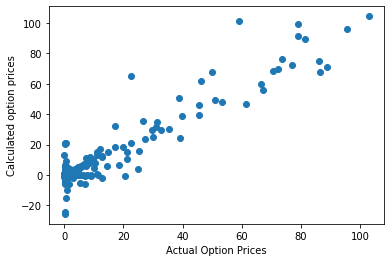

In [16]:
plt.scatter(market_prices,heston_prices)
plt.xlabel('Actual Option Prices')
plt.ylabel('Calculated option prices')